In [24]:
from BaroSphere import BaroSphere
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy
plt.style.use('dark_background')
B=BaroSphere(
    ntrunc=85,
    dt=1800,
    damping_order=4,
    efold=3*3600,
    nlat=128
)

print(B.lons1.shape,B.lats1.shape)

# note - dt=1800 works well for up to T85
# 100 days at T85 takes 40 seconds

(256,) (128,)


In [25]:
B.hyperdiff_fact

array([1.        , 1.        , 1.        , ..., 0.85925007, 0.84648172,
       0.84648172])

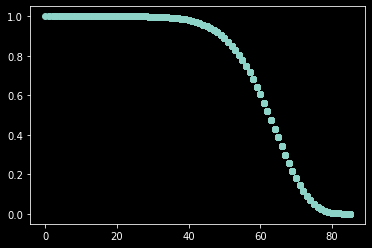

In [26]:
plt.plot(B.indxn,np.power(B.hyperdiff_fact,1*24*3600/B.dt),'o')
#plt.xlim([0,)
#plt.ylim([0.9,1])

In [3]:
#total number of steps to take
Nsteps = int(60*24*3600/B.dt)
#how often to take snapshots
dN_snap = int(6*3600/B.dt)
#total number of snapshots
Nsnaps = int(Nsteps/dN_snap)

print(Nsteps,dN_snap,Nsnaps)

#first time step 
vrt0 = 0*B.vrtg_unstable_jet(m=12,A=8e-5) #initialiae with 0 
vrt1 = vrt0 + B.dt * B.vrt_time_tendency(vrt0)

B.vrtg_m1 = vrt0
B.vrtg = vrt0

#initialize the snapshots
vrt = np.zeros([Nsnaps+1,B.nlat,B.nlon])
vrt[0] = vrt0
ksnap = 1

#stocahstic realization decay time scale
tau=2*3600*24
#noise strength
NS=1.e-10

#damping timescale for the mean drag
tdamp=10*24*3600

#spectral filter for the noise realization
B.w_indxm_damp = np.ones(len(B.indxm))
B.w_indxm_damp[B.indxm>14] = 0
B.w_indxm_damp[B.indxm<10] = 0

#noise realization container
W = np.zeros(len(B.w_indxm_damp))
#sine of latitude
s=np.sin(B.lats*B.a)
#grid space filter
damping_window=np.exp( - np.power( (s - 0.7) / 0.2 ,2) ) 


#main time loop
for i in range(1,Nsteps+1):
    #timestep the model
    B.RA_leapfrog()
    #time step the noise realization
    W = (1-B.dt/tau) * W + NS*np.sqrt(B.dt / (2 * tau) )*np.random.randn(len(W))
    #add the noise to the model spectrally
    B.vrtg += B.x.spectogrd(B.w_indxm_damp * W * B.dt) * damping_window    
    #apply mean "drag" to the model
    B.vrtg = B.vrtg * tdamp / (tdamp + B.dt)

    #store data sometimes
    if i%dN_snap == 0:
        vrt[ksnap] = np.copy(B.vrtg)
        print(i,i*B.dt/3600/24,ksnap,np.max(vrt[ksnap]))
        ksnap += 1


2880 12 240
12 0.25 1 9.595543792831427e-06
24 0.5 2 2.083081736088016e-05
36 0.75 3 3.578676575922607e-05
48 1.0 4 4.839325994601678e-05
60 1.25 5 5.94343988635343e-05
72 1.5 6 7.846486597881496e-05
84 1.75 7 0.00010593165256268889
96 2.0 8 0.00011783880530130466
108 2.25 9 0.00012357327157705092
120 2.5 10 0.00012801742285737871
132 2.75 11 0.00012791311376091102
144 3.0 12 0.00013050340065682257
156 3.25 13 0.00014855190937304694
168 3.5 14 0.00015505810758087343
180 3.75 15 0.0001531986233133536
192 4.0 16 0.00016351571217520074
204 4.25 17 0.00016203553371301808
216 4.5 18 0.00016337103285902254
228 4.75 19 0.0001580991032930273
240 5.0 20 0.00015580820949775265
252 5.25 21 0.00015988114353834715
264 5.5 22 0.00016102482605407986
276 5.75 23 0.0001732014427484321
288 6.0 24 0.00018098527128012414
300 6.25 25 0.00022161640168754325
312 6.5 26 0.0002542713931964985
324 6.75 27 0.0002663183604946008
336 7.0 28 0.00024300062324146966
348 7.25 29 0.00023013202032062715
360 7.5 30 0.000

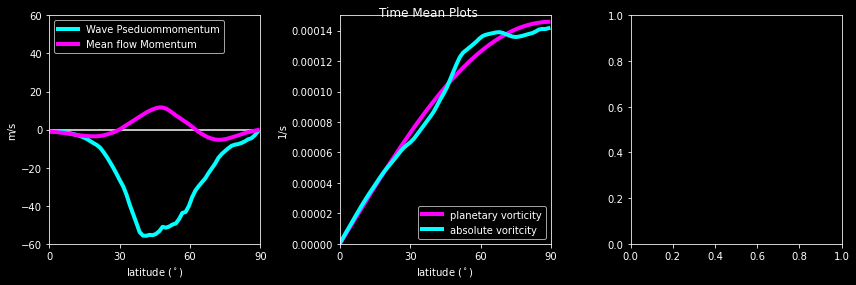

In [13]:
u,v=B.get_uv_vrtg(vrt[120:].mean(axis=0))

beta=B.omega*2*np.cos(np.pi/4)/B.rsphere

A=-np.power(vrt-vrt.mean(axis=-1)[:,:,np.newaxis],2)/(2*beta)
A=A[20:].mean(axis=0)

lw=4

plt.figure(0,figsize=(12,4))

plt.subplot(1,3,1)

plt.ylabel('m/s')
plt.xlabel('latitude ($^\\circ$)')
plt.xlim([0,90])
plt.plot(B.lats1,0*B.lats1,'w')
plt.xticks(np.linspace(0,90,4))
plt.plot(B.lats1,A.mean(axis=-1),label='Wave Pseduommomentum',
linewidth=lw,color='cyan',alpha=1,linestyle='-')
plt.plot(B.lats1,u.mean(axis=-1),label='Mean flow Momentum',
linewidth=lw,color='magenta',alpha=1,linestyle='-')
plt.legend(loc=2)
plt.ylim([-60,60])

# plt.axvline(180/np.pi*np.arcsin(0.55),linestyle='--',color='green')
#plt.axvline(180/np.pi*np.arcsin(0.85),linestyle='--',color='green')

# plt.annotate('Stirring \nRegion',(15,-30),color='white')

#plt.gca().twinx()
#plt.plot(B.lats1,damping_window[:,0],'w--',label='Stirring Region')
#plt.ylabel('')

plt.legend(loc=2)

plt.subplot(1,3,2)

plt.ylabel('1/s')
plt.xlabel('latitude ($^\\circ$)')
plt.xticks(np.linspace(-90,90,7))
plt.plot(B.lats1,B.f.mean(axis=-1),
label='planetary vorticity',linewidth=lw,color='magenta')
plt.plot(B.lats1,B.f.mean(axis=-1)+vrt[20*4:].mean(axis=(0,-1)),
label='absolute voritcity',linewidth=lw,color='cyan')
# plt.axvline(180/np.pi*np.arcsin(0.55),linestyle='--',color='green')
# plt.axvline(180/np.pi*np.arcsin(0.85),linestyle='--',color='green')
plt.xlim([0,90])
plt.ylim([-1.5e-4*0,1.5e-4])
plt.legend()

plt.subplot(1,3,3)




plt.suptitle('Time Mean Plots')

plt.tight_layout()

plt.savefig('TimeMean.png')

<Figure size 432x288 with 0 Axes>

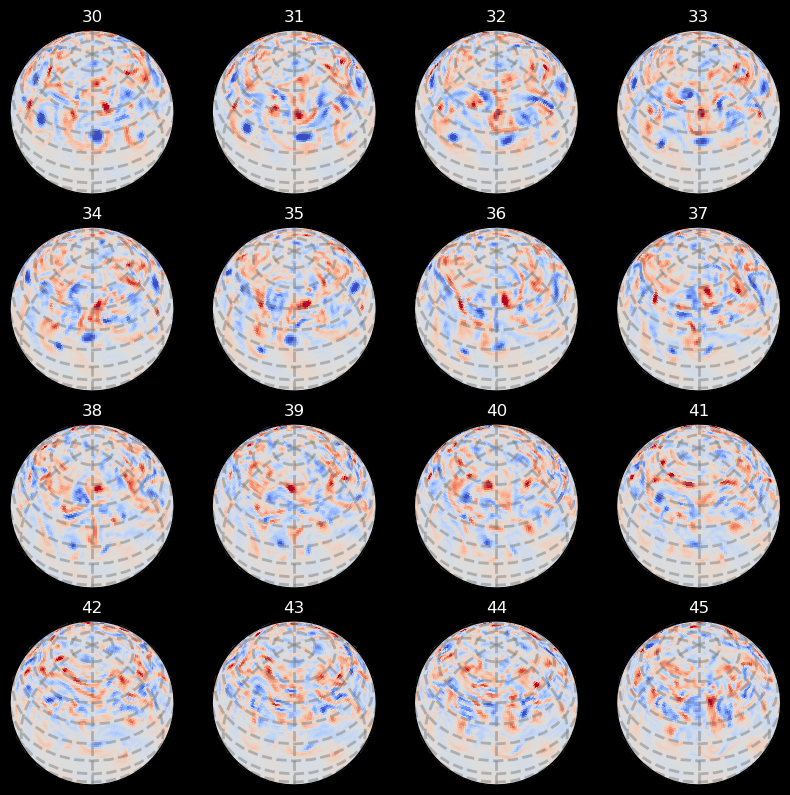

In [7]:

# look at some sample data to make sure things are working 
plt.clf()
plt.figure(0,figsize=(10,10),dpi=100)
lim=5e-5
crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=45)
cproj=ccrs.Orthographic(-0, 0)
for i in range(0,16):
    ind=120+i*4
    ax=plt.subplot(4,4,i+1,projection=cproj)
    ax.pcolormesh(B.lons1,B.lats1,vrt[ind],
    vmin=-1.e-4,vmax=1.e-4,cmap=plt.cm.coolwarm,
    transform=crs)    
    gl = ax.gridlines(crs=crs, draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    plt.title(int((dN_snap*B.dt*ind)/(3600*24)))
#    plt.title(1+i*0.5)
#    plt.yticks([])
#    plt.xticks([])
#    plt.ylim([-90,90])
#plt.savefig('test0.png')